In [3]:
from datasets import load_dataset #Data set with rich set of images

# download the dataset
imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenet

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to C:/Users/raaja/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

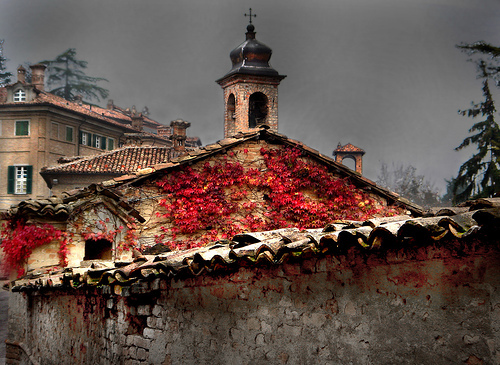

In [4]:
imagenet[3264]['image']

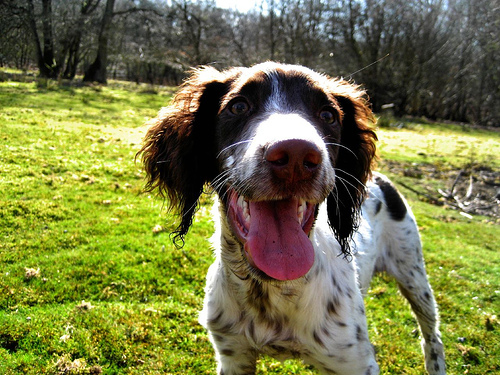

In [5]:
imagenet[5874]['image']

In [6]:
import numpy as np #translate this images into numpy array

# generate an array from the original dataset
images_training = []

for n in range(0,len(imagenet)):
    images_training.append(np.array(imagenet[n]['image']))

In [7]:
import cv2 #we are goona convert all rgb(3d) to gray scale (2d)

# convert images to grayscale
bw_images = []
for img in images_training:
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

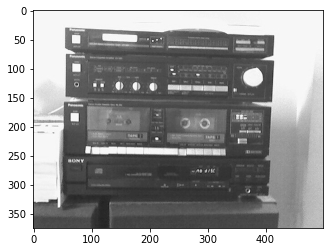

In [8]:
import matplotlib.pyplot as plt #new gray sclae images

plt.imshow(bw_images[1], cmap='gray')
plt.show()

In [18]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)
#so here all the key as well as the descriptors are there we could also the dimension of it.

In [19]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 9469
indexes: []
len after: 9469


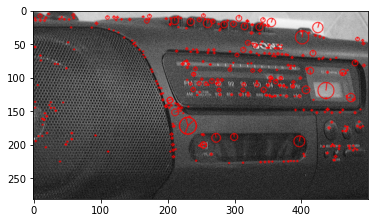

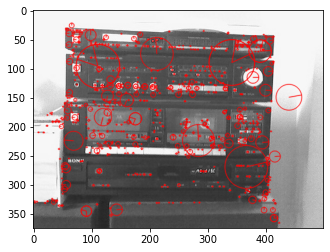

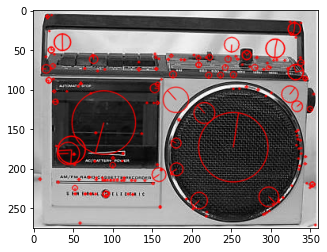

In [20]:
output_image = [] #what does key points and descriptors look like ?
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()  

In [21]:
import numpy as np #select 1000 random images

# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(imagenet)+1, 1000).tolist()
len(sample_idx)

1000

In [22]:
# extract the sample from descriptors
# (we don't need keypoints for training)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [23]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [24]:
# check the shape 
all_descriptors.shape

(1130933, 128)

In [25]:
# we can count the number of descriptors contained in each image descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [544, 1507, 282, 688, 718]
count all: 1130933


In [26]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans
# SETs the number of visual words we want
k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [27]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [28]:
# load the visual features, number of clusters, and codebook 
k, codebook = joblib.load("bovw-codebook.pkl")

In [29]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [30]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([ 84,  26,  45, 147, 147]), 397)

In [31]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[84].shape  # (all have the same dimensionality)

(128,)

In [32]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [33]:
frequency_vectors.shape

(9469, 200)

In [34]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

84: 4.0
22: 0.0
45: 3.0
172: 0.0


In [35]:
frequency_vectors[0][:20]

array([1., 6., 3., 0., 0., 1., 2., 6., 0., 0., 3., 3., 1., 2., 0., 1., 3.,
       0., 3., 1.])

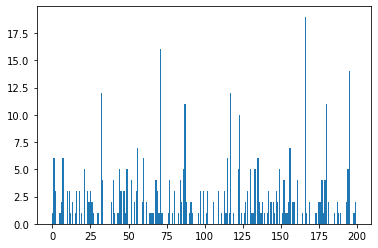

In [36]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

In [37]:
# N is the number of images, i.e. the size of the dataset
N = 9469

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [38]:
df.shape, df[:5]

((200,), array([7306, 7506, 7816, 7124, 7390]))

In [39]:
idf = np.log(N/ df)
idf.shape, idf[:5]

((200,), array([0.25932738, 0.2323206 , 0.19185039, 0.28455394, 0.24789557]))

In [40]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((9469, 200),
 array([0.25932738, 1.39392363, 0.57555117, 0.        , 0.        ]))

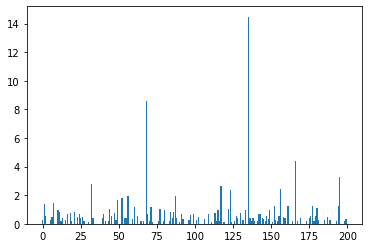

In [41]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

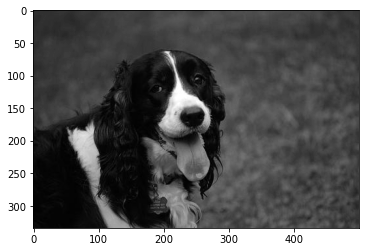

In [42]:
search_i = 6595

plt.imshow(bw_images[search_i], cmap='gray')
plt.show()

In [43]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

Min cosine similarity: 0.0
Max cosine similarity: 1.0


In [44]:
cosine_similarity.shape

(9469,)

In [45]:
cosine_similarity

array([0.19280717, 0.3021753 , 0.19674115, ..., 0.46532248, 0.32161842,
       0.31115087])

In [46]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([6595, 6021, 5794, 6245, 6513], dtype=int64)

In [47]:
cosine_similarity[idx[0]]

1.0

6595: 1.0


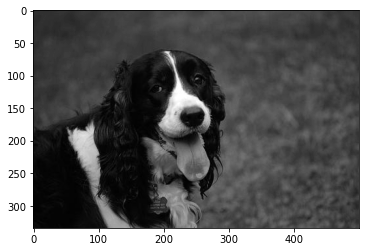

6021: 0.7486


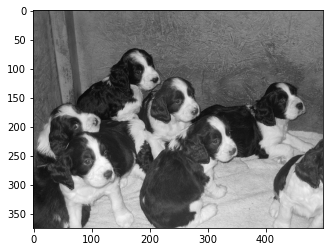

5794: 0.7218


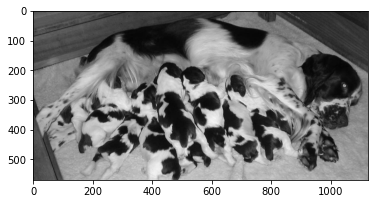

6245: 0.7193


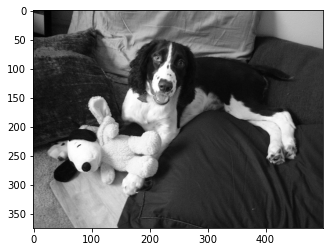

6513: 0.7126


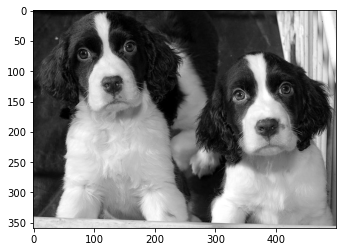

In [48]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

In [49]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

Search image:


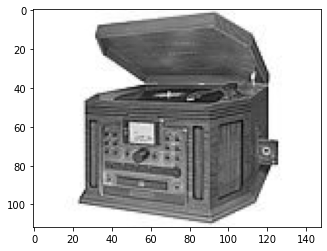

-----------------------------------------------------
10: 1.0


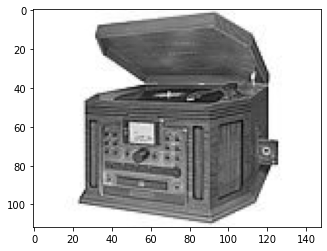

3394: 0.5005


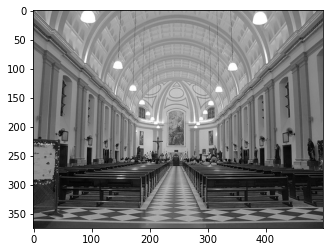

3246: 0.4922


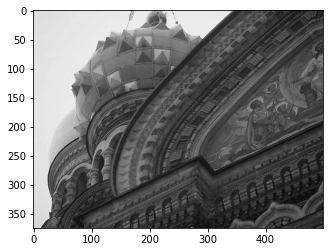

2461: 0.4865


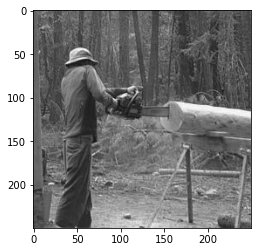

7575: 0.4863


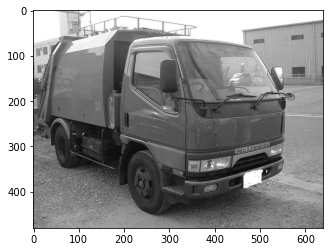

In [50]:
search(10)

Search image:


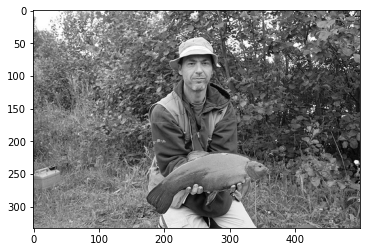

-----------------------------------------------------
1200: 1.0


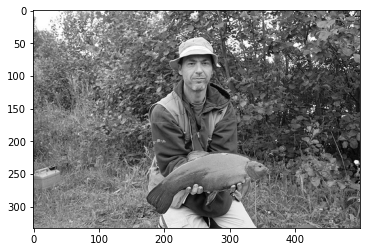

6398: 0.9419


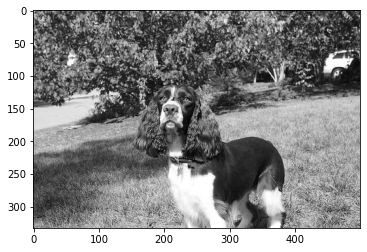

1739: 0.9382


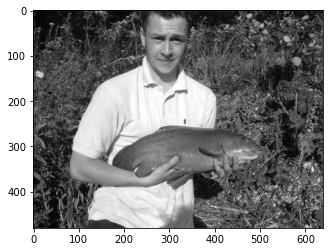

7457: 0.9373


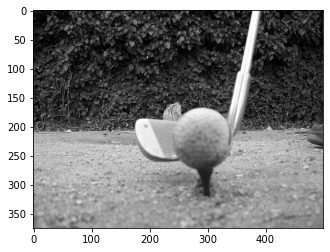

7381: 0.936


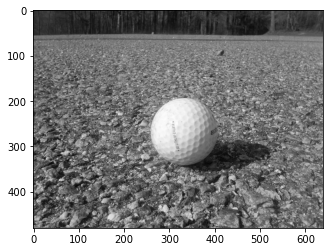

In [51]:
search(1200)

Search image:


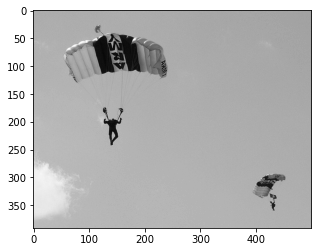

-----------------------------------------------------
4000: 1.0


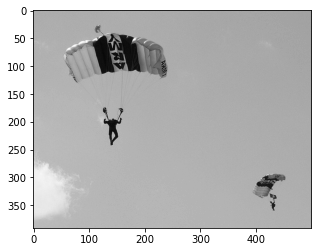

7435: 0.807


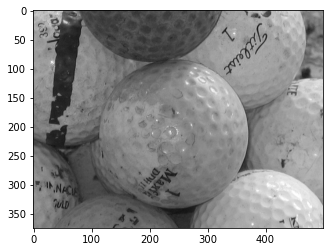

6054: 0.7941


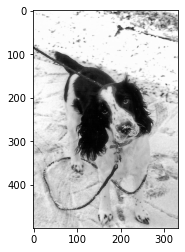

7186: 0.7898


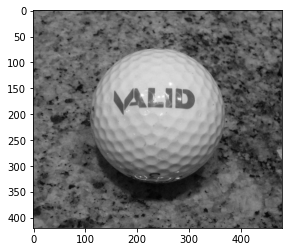

4257: 0.7839


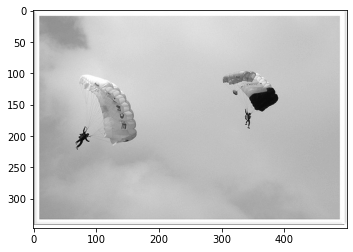

In [54]:
search(4000)

Search image:


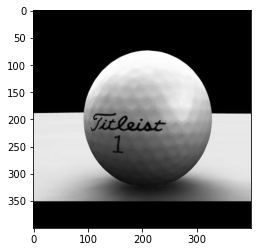

-----------------------------------------------------
6921: 1.0


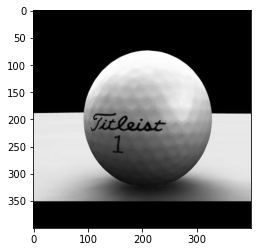

7119: 0.7112


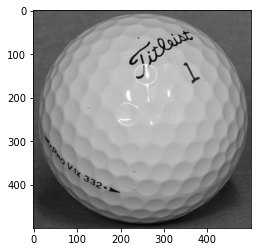

7051: 0.7106


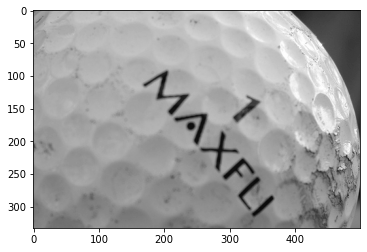

6896: 0.701


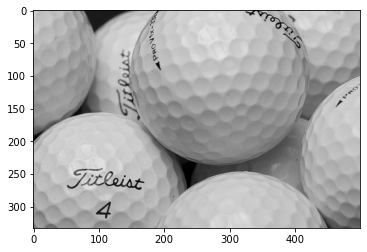

7447: 0.6706


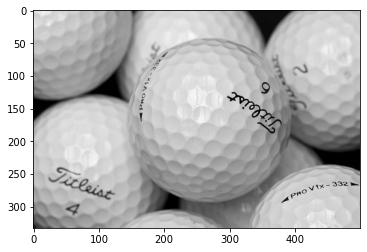

In [53]:
search(6921)

Search image:


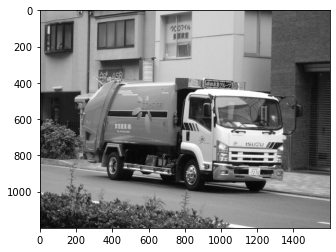

-----------------------------------------------------
8052: 1.0


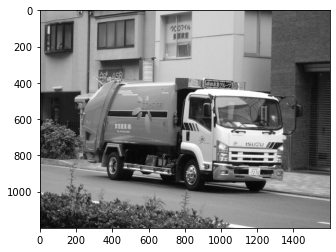

7840: 0.9314


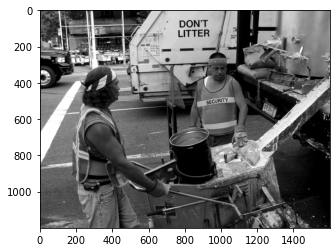

8093: 0.928


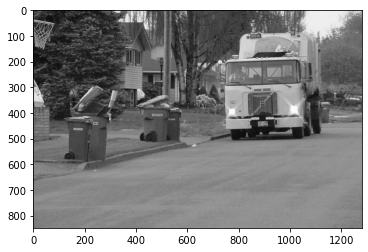

3407: 0.9172


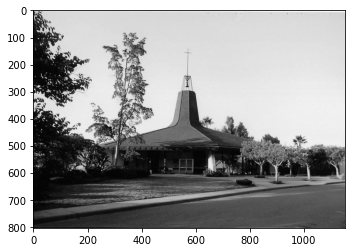

9054: 0.9162


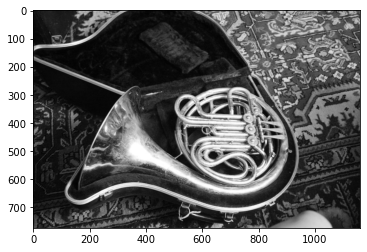

In [52]:
search(8052)

In [2]:
!pip install datasets opencv-contrib-python opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.10.1
    Uninstalling fsspec-2021.10.1:
      Successfully uninstalled fsspec-2021.10.1
